In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.constants import g0

In [2]:
def load_report(path):
    return np.fromfile(path, sep = ' ').reshape((-1,7))

mjd_unixtimestamp_offset = 10587.5
seconds_in_day = 3600 * 24

def mjd2unixtimestamp(m):
    return (m - mjd_unixtimestamp_offset) * seconds_in_day

In [3]:
pre = load_report('orbit/remote_sensing/Tianwen1_pre_remote_sensing.txt')
post = load_report('orbit/remote_sensing/Tianwen1_post_remote_sensing.txt')[::-1]
t = np.datetime64('1970-01-01') + (mjd2unixtimestamp(pre[:,0]) * 1e9) * np.timedelta64(1, 'ns')

In [4]:
post_interp = np.empty_like(pre)
post_interp[:,0] = pre[:,0]
for j in range(1, post_interp.shape[1]):
    post_interp[:,j] = np.interp(post_interp[:,0], post[:,0], post[:,j], left = np.nan, right = np.nan)

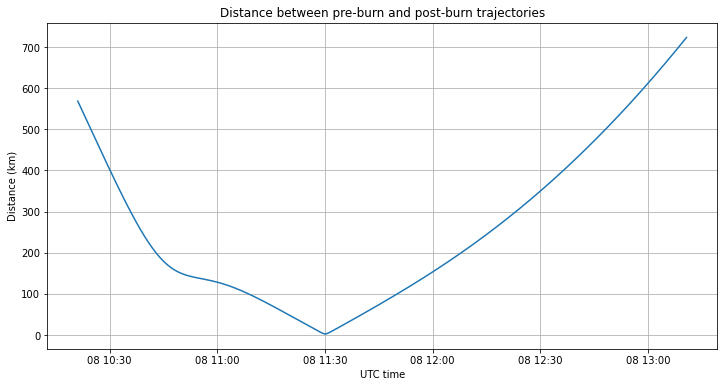

In [5]:
plt.figure(figsize = (12,6), facecolor = 'w')
dist = np.sqrt(np.sum((pre[:,1:4] - post_interp[:,1:4])**2, axis = 1))
plt.plot(t, dist)
plt.grid()
plt.title('Distance between pre-burn and post-burn trajectories')
plt.xlabel('UTC time')
plt.ylabel('Distance (km)');

In [6]:
sel = ~np.isnan(dist)
burn_idx = np.argmin(dist[sel])
t[sel][burn_idx]

numpy.datetime64('2021-11-08T11:30:02.224999936')

In [7]:
dist[sel][burn_idx]

2.736255767970403

In [8]:
# Periapsis time
periapsis_idx = np.argmin(np.sqrt(np.sum((pre[sel,1:4])**2, axis = 1)))
t[sel][periapsis_idx]

numpy.datetime64('2021-11-08T10:50:33.225000192')

In [9]:
# Periapsis time
periapsis_idx = np.argmin(np.sqrt(np.sum((post_interp[sel,1:4])**2, axis = 1)))
t[sel][periapsis_idx]

numpy.datetime64('2021-11-08T10:49:02.225000192')

In [10]:
delta_v_ms = (post_interp[sel][burn_idx, 4:] - pre[sel][burn_idx, 4:]) * 1e3
delta_v_ms

array([-14.52303335,  36.68626084,  70.86143233])

In [11]:
delta_v_norm = np.sqrt(np.sum(delta_v_ms**2))
delta_v_norm

81.10575087447863

In [12]:
# Burn of 4 x 120 N
ve = 321.6 * u.s * g0
F = 4 * 120 * u.N
m0 = 1600 * u.kg  # estimated to give burn time around 260 s
T = (ve * m0 / F * (1 - np.exp(-delta_v_norm * u.m/u.s / ve))).to(u.s)
T

<Quantity 266.90582715 s>

In [13]:
mdot = -(F/ve).to(u.kg/u.s)
deltam = mdot * T
deltam

<Quantity -40.6221193 kg>

In [14]:
# VNB frame
r = pre[sel][burn_idx, 1:4]
v = pre[sel][burn_idx, 4:]
rr = r / np.sqrt(np.sum(r**2))
vv = v / np.sqrt(np.sum(v**2))
n = np.cross(rr, vv)
n /= np.sqrt(np.sum(n**2))
b = np.cross(vv, n)
U = np.matrix([vv, n, b]).T

In [15]:
# Delta-V in VNB frame
U.T @ delta_v_ms

matrix([[-80.44680221,  -0.09011278, -10.31730189]])

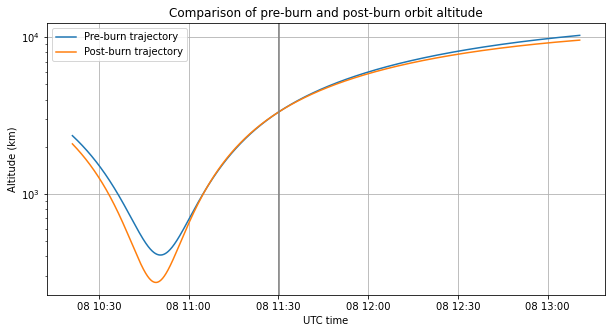

In [16]:
plt.figure(figsize=(10, 5), facecolor='w')
plt.semilogy(t[sel], np.sqrt(np.sum(pre[sel, 1:4]**2, axis=1))-3389.5)
plt.semilogy(t[sel], np.sqrt(np.sum(post_interp[sel, 1:4]**2, axis=1))-3389.5)
plt.axvline(x=t[sel][burn_idx], color='grey')
plt.grid()
plt.legend(['Pre-burn trajectory', 'Post-burn trajectory'])
plt.ylabel('Altitude (km)')
plt.xlabel('UTC time')
plt.title('Comparison of pre-burn and post-burn orbit altitude');